In [16]:
import sys
from dotenv import dotenv_values
from binance.spot import Spot
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

In [17]:
print(sys.version)
from binance.__version__ import __version__ as binance_version
print(f'Binance client: {binance_version}')
print(f'Pandas verrsion: {pd.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')
print(f'Seaborn version: {sns.__version__}')

3.11.2 (main, Feb  8 2023, 00:00:00) [GCC 12.2.1 20221121 (Red Hat 12.2.1-4)]
Binance client: 2.0.0
Pandas verrsion: 1.5.3
Matplotlib version: 3.7.1
Seaborn version: 0.12.2


In [18]:
sns.set_style('whitegrid')
sns.set_context("paper")
config = dotenv_values('env')

In [19]:
api_key = config.get('API_KEY')
secret_key = config.get('SECRET_KEY')
client = Spot(api_key, secret_key)
timestamp = binance_client.time()["serverTime"]
print(f'Server time: {timestamp} ~ {datetime.fromtimestamp(timestamp / 1000)}')

Server time: 1679568864957 ~ 2023-03-23 17:54:24.957000


In [20]:
tickers = client.ticker_24hr()
tickers = pd.DataFrame(tickers)
tickers = tickers.astype({'symbol': 'str', 'lastPrice': 'float64'})
tickers = tickers[tickers['symbol'].str.endswith('BUSD')]
tickers = tickers.assign(asset=lambda r: r.symbol.str[:-4])
tickers.reset_index(drop=True, inplace=True)

In [21]:
tickers.head()

,symbol,priceChange,priceChangePercent,weightedAvgPrice,prevClosePrice,lastPrice,lastQty,bidPrice,bidQty,askPrice,...,highPrice,lowPrice,volume,quoteVolume,openTime,closeTime,firstId,lastId,count,asset
0,BNBBUSD,-0.90000000,-0.275,325.21171667,326.80000000,325.8000,0.61300000,325.80000000,29.45000000,325.90000000,...,331.30000000,316.80000000,260935.26200000,84859204.49350000,1679482465087,1679568865087,201658446,201820423,161978,BNB
1,BTCBUSD,-512.60000000,-1.818,27838.13540553,28193.65000000,27681.0500,0.00092000,27681.05000000,5.00600000,27681.06000000,...,28922.00000000,26666.00000000,43524.56327000,1211642685.77700920,1679482465767,1679568865767,965113834,965980925,867092,BTC
2,XRPBUSD,-0.00950000,-2.101,0.43507310,0.45210000,0.4426,2783.00000000,0.44260000,94913.00000000,0.44270000,...,0.45600000,0.40980000,277102515.00000000,120559851.14830000,1679482462028,1679568862028,84984732,85245615,260884,XRP
3,ETHBUSD,-36.54000000,-2.038,1771.32622720,1792.60000000,1756.0600,0.01070000,1756.06000000,10.13070000,1756.07000000,...,1822.89000000,1714.33000000,316226.95070000,560141091.52307400,1679482465331,1679568865331,469966917,470435671,468755,ETH
4,BCHABCBUSD,0.00000000,0.000,0.00000000,220.16000000,0.0000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,1678936363566,1679022763566,-1,-1,0,BCHABC


In [22]:
info = client.account()

In [23]:
balances = pd.DataFrame(info['balances'])
balances = balances.astype({'asset': 'str', 'free': 'float64', 'locked': 'float64'})
balances = balances.loc[(balances['free'] > 0) | (balances['locked'] > 0)]
balances = balances.assign(total=lambda r: r.free + r.locked)
balances = balances[balances['asset'] != 'NFT']
for index, balance in balances.iterrows():
    try:
        price = tickers[tickers['asset'] == balance['asset']]['lastPrice'].iloc[0]
        balances.loc[index, ['free', 'locked', 'total']] = balance[['free', 'locked', 'total']] * price
    except Exception as ex:
        print(balance['asset'], ex)
balances.reset_index(drop=True, inplace=True)

USDT single positional indexer is out-of-bounds
BUSD single positional indexer is out-of-bounds
ETHW single positional indexer is out-of-bounds


In [24]:
balances.head()

,asset,free,locked,total
0,BTC,0.177436,0.0000,0.177436
1,ETH,0.167528,0.0000,0.167528
2,NEO,0.000000,7.9552,7.955200
3,BNB,0.042445,85.3596,85.402045
4,QTUM,0.000000,5.6270,5.627000


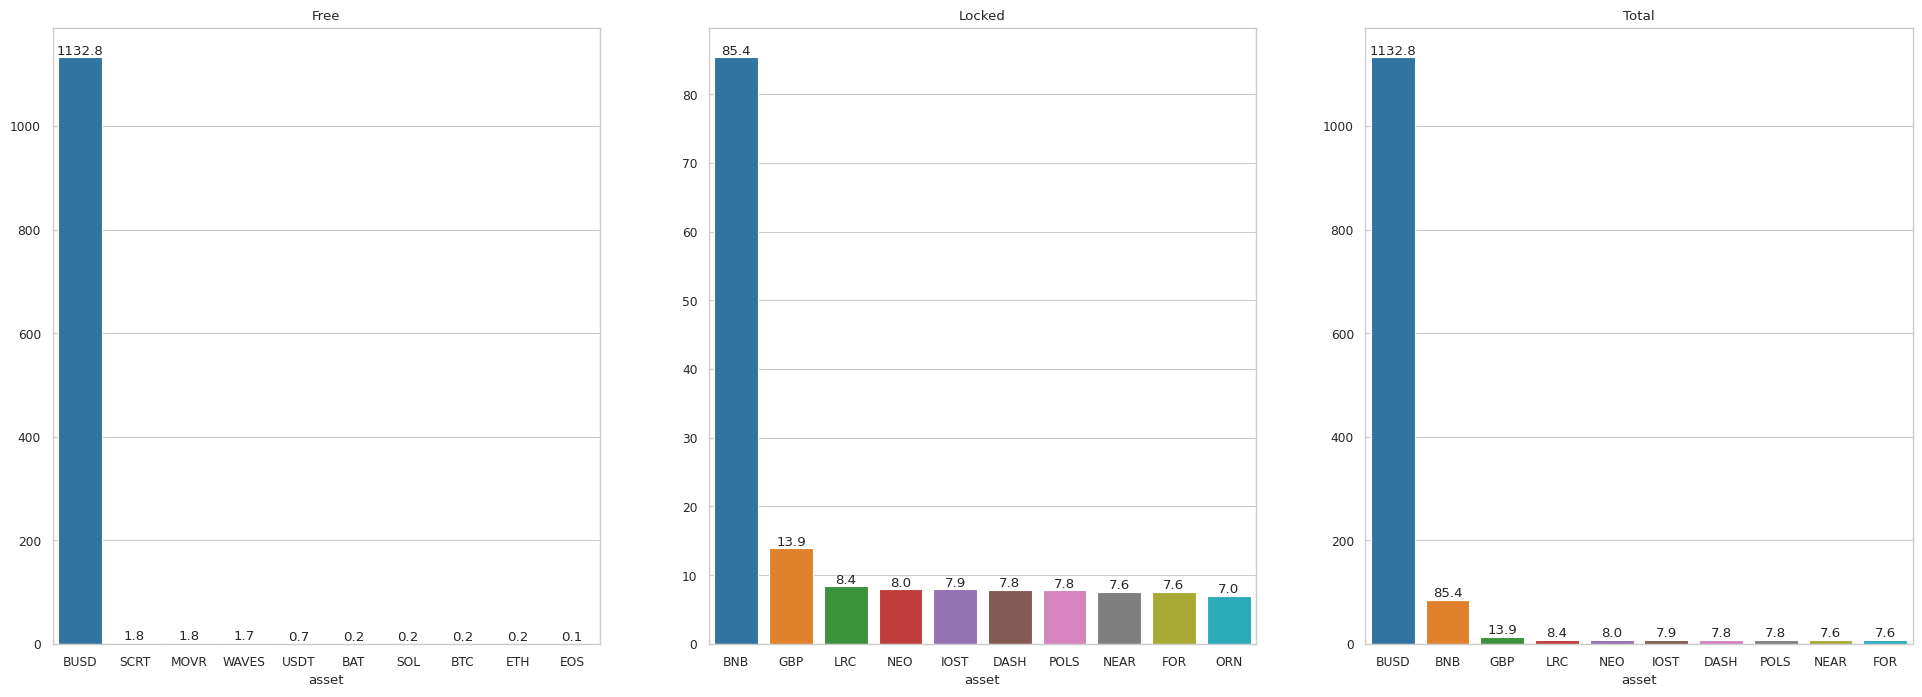

In [25]:
%matplotlib inline
top = 10
colors = sns.color_palette()
figure, axes = plt.subplots(1, 3, figsize=(24, 8))
df = balances.sort_values(by='free', ascending=False)[:top]
sns.barplot(ax=axes[0], data=df, x='asset', y='free').set(title='Free', ylabel=None)
for bars in axes[0].containers:
    axes[0].bar_label(bars, fmt='%.1f')
df = balances.sort_values(by='locked', ascending=False)[:top]
sns.barplot(ax=axes[1], data=df, x='asset', y='locked').set(title='Locked', ylabel=None)
for bars in axes[1].containers:
    axes[1].bar_label(bars, fmt='%.1f')
df = balances.sort_values(by='total', ascending=False)[:top]
sns.barplot(ax=axes[2], data=df, x='asset', y='total').set(title='Total', ylabel=None)
for bars in axes[2].containers:
    axes[2].bar_label(bars, fmt='%.1f')
plt.show()